In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import time
from datetime import date

pd.set_option('display.max_rows', None)

In [2]:
# example of using the vgg16 model as a feature extraction model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense

from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path_img = "/content/drive/MyDrive/OpenClassRooms/Data_Scientist/Projet_6/images/"

# Chargement des données

In [28]:
path = "/content/drive/MyDrive/OpenClassRooms/Data_Scientist/Projet_6/flipkart_com-ecommerce_sample_1050.csv"
flipkart = pd.read_csv(path)

In [29]:
b_renom = False

file_0 = os.path.join(path_img, "0.jpg")   # Si le fichier 0.jpg existe, alors le renommage dans le répertoire a déjà été fait

try:
  with open(file_0): pass
except IOError:
  print("Renommage nécessaire")
  b_renom = True

In [30]:
# Renommage des images - dans le répertoire "./images" 
#                      - dans le dataframe
#
#   ex: la 1ère image du dataframe 'flipkart_img' ne s'appelle plus "55b85ea15a1536d46b7190ad6fff8ce7.jpg" mais "0.jpg"

import os

for i in flipkart.index:
    
    # Renommage dans le REPERTOIRE (si jamais fait auparavant)
    if b_renom == True:
      old_file = os.path.join(path_img, flipkart["image"][i])
      new_file = os.path.join(path_img, str(i)+".jpg")
      os.rename(old_file, new_file)
    
    # Renommage dans le DATAFRAME
    flipkart.at[i, 'image'] = str(i)+".jpg"

flipkart.head(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,0.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,1.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,2.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."


In [31]:
# Nettoyage colonnes
flipkart = flipkart.drop(['uniq_id','crawl_timestamp','product_url','pid', 'retail_price','discounted_price', 'description',
                                  'is_FK_Advantage_product','product_rating','overall_rating','brand','product_specifications'], 1)

# Renommage colonnes
flipkart.columns = ['product', 'category', 'image']

In [32]:
# Récupération de la catégorie de 1er niveau pour chaque produit

import string

def get_first_categ(categories):
    deb = categories.find('\"')            # indice du 1er caractère '#'
    fin = categories.find('>')             # indice du 1er caractère '>'
    first_categ = categories[deb+1:fin-1]  # La 1ere catégorie est entre des deux indices
    first_categ.rstrip()                   # sup espace en fin de chaine
    return(first_categ)

flipkart['category'] = flipkart['category'].apply(get_first_categ)

In [25]:
from sklearn.preprocessing import LabelEncoder

X = flipkart['category']

transformer = LabelEncoder()
flipkart.insert(0, 'categ', transformer.fit_transform(X))

In [26]:
flipkart.head(3)

,categ,product,category,image
0,4,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing,0.jpg
1,0,Sathiyas Cotton Bath Towel,Baby Care,1.jpg
2,0,Eurospa Cotton Terry Face Towel Set,Baby Care,2.jpg


In [15]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [33]:
# Extraire  des vecteurs d'une image

import cv2

print("\n\nTemps estimé :  10 minutes sur Google Colab\n")

VGG_model = VGG16(weights="imagenet", include_top=False)

def extract_vector(images):
  resnet_feature_list = []

  for i in range(1050):
    im = path_img+images["image"][i]
    im = cv2.imread(im)
    im = cv2.resize(im, (224,224))
    img = preprocess_input(np.expand_dims(im.copy(), axis=0))   # ajoute 1 dimension -> (1, 224, 224, 3)

    resnet_feature = VGG_model.predict(img)                     # On récupère les Deep Feature par appel à predict
    resnet_feature_np = np.array(resnet_feature)
    resnet_feature_list.append(resnet_feature_np.flatten())

  return(np.array(resnet_feature_list))

H = extract_vector(flipkart)

print(H.shape)   # (1050, 25088)



Temps estimé :  10 minutes sur Google Colab

58892288/58889256 [==============================] - 3s 0us/step
(10, 25088)


In [34]:
df_Deep_feature = pd.DataFrame(H)
df_Deep_feature = df_Deep_feature.head(6)
df_Deep_feature

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,25048,25049,25050,25051,25052,25053,25054,25055,25056,25057,25058,25059,25060,25061,25062,25063,25064,25065,25066,25067,25068,25069,25070,25071,25072,25073,25074,25075,25076,25077,25078,25079,25080,25081,25082,25083,25084,25085,25086,25087
0,0.0,0.0,0.0,0.0,9.860709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.767503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,27.967365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.780991,0.0,0.0,0.0,0.0,0.0,23.742998,0.000000,3.781429,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,52.034924,0.0,0.0,23.442303,26.424536,0.000000,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,1.571128,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,18.878702,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.46906,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,31.265146,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,77.541100,40.626038,0.0,0.0,0.0,5.317968,0.0,0.000000,0.0,1.627109,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,6.332284,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,26.201574,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,7.454960,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,5.057821,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.246152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,14.012780,0.0,4.518832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,37.759201,0.0,0.0,0.0,0.0,0.0,0.776066,3.594411,0.000000,0.0,0.0,0.0,15.375066,56.824570,0.0,0.0,0.0,0.000000,0.0,23.523211,0.0,34.433182,0.0,0.0,17.568617,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,30.910145,0.000000,22.469364,0.0,0.000000,0.0
5,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,15.985387,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,46.684280,0.000000,0.0,0.0,0.0,9.587667,0.0,0.000000,0.0,27.161224,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0


In [35]:
#  Cluster selon K-means

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


km = KMeans(n_clusters=7, init='k-means++', n_init=10)
km.fit(H)
clusters_CNN = km.labels_    # Récupération des clusters attribués à chaque produit

set(clusters_CNN)

{0, 1, 2, 3, 4, 5, 6}

In [36]:
# Affichage du nombre de produits pour chaque cluster

products = flipkart['product']

productCluster = pd.DataFrame({"Produit": products, "cluster": clusters_CNN})   # Dataframe associant le produit au cluster

# Nombre de clients par cluster :
productCluster['product'] = 1
cumul_km_cnn = productCluster.groupby(['cluster']).sum().reset_index()
cumul_km_cnn.columns = ['cluster', 'nb_produits']
#cumul_km_cnn.to_csv("cumul_km_cnn.csv", index=False, header=True, sep=';')
print(cumul_km_cnn)

flipkart['cluster'] = clusters_CNN    # Association du cluster à chaque produit
flipkart.head(3)

ValueError: ignored

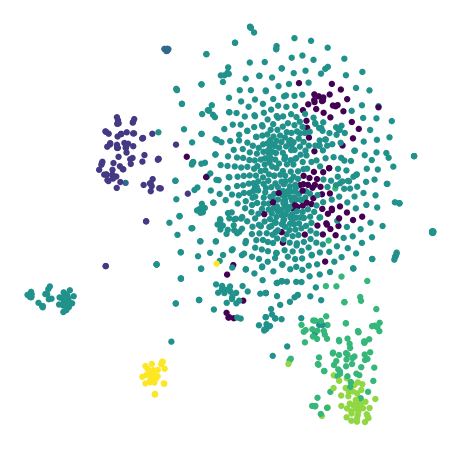

In [ ]:
from sklearn.manifold import TSNE

def fashion_scatter(x):

    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=clusters_CNN)
    ax.axis('off')
    ax.axis('tight')
    plt.show()

tsne = TSNE(n_components=2)
X_2d = tsne.fit_transform(H)
fashion_scatter(X_2d)

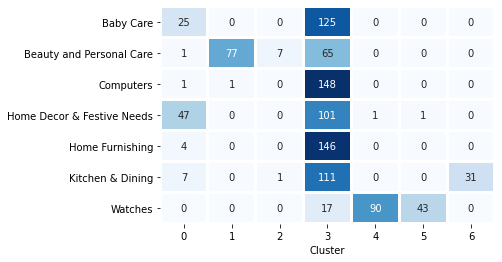

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(flipkart['categ'], flipkart['cluster'])

df_cm = pd.DataFrame(cm, columns=np.unique(flipkart['categ']), index = np.unique(flipkart['category']))
df_cm.columns.name = 'Cluster'

ax = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", linewidths=2, cbar=False)


In [ ]:
from sklearn import metrics

rand_score = metrics.adjusted_rand_score(flipkart['category'], flipkart['cluster'])

print("Rand Score ajusté =\n", rand_score)

Rand Score ajusté =
 0.1082492175234294
